# Generic file for analysis of VIND results

Some python magic

In [3]:
# load Python/Theano stuff
%load_ext autoreload 
# Show figures inlinewith the code
%matplotlib inline

## Import standard python libraries

In [4]:
import sys
import cPickle as pickle
import numpy as np
import dill

## Import local libraries (append the path to the code to sys.path)

In [5]:
import theano
import theano.tensor as T

import lasagne

from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify, sigmoid
import matplotlib.pyplot as plt

##### INTERNAL PACKAGES #####

sys.path.append('/Users/danielhernandez/Work/time_series/vae_nlds_rec_algo_v2/')

from LatEvModels import LocallyLinearEvolution
from ObservationModels import GaussianObsTSGM, PoissonObsTSGM

from RecognitionModels import SmoothingNLDSTimeSeries
from OptimizerVAEC_TS import VAEC_NLDSOptimizer

##### PREPARATORY CODE #####

theano.config.optimizer = 'None'

## Load the data

In [6]:
data_dir = '/Users/danielhernandez/Work/time_series/vae_nlds_rec_algo_v2/data/'
this_data_dir = 'poisson_data_002/'
f1data = open(data_dir + this_data_dir + 'datadict', 'rb+')

data = pickle.load(f1data)

## Some data visualization for the lolz

Data in the data dictionary: ['Xtrain', 'Xvalid', 'Yvalid', 'Ytrain']


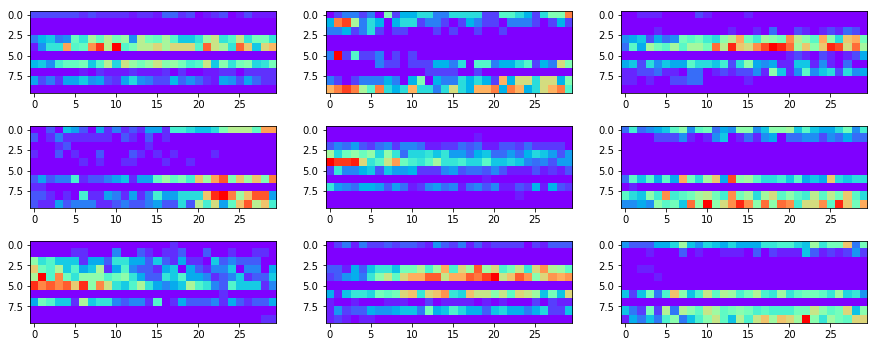

In [62]:
print 'Data in the data dictionary:', data.keys()
Ytrain = data['Ytrain']

plt.figure(figsize=(15,6))
plt.subplot(331)
plt.imshow(Ytrain[0].T, cmap='rainbow', interpolation='nearest')
plt.subplot(332)
plt.imshow(Ytrain[1].T, cmap='rainbow', interpolation='nearest')
plt.subplot(333)
plt.imshow(Ytrain[2].T, cmap='rainbow', interpolation='nearest')
plt.subplot(334)
plt.imshow(Ytrain[5].T, cmap='rainbow', interpolation='nearest')
plt.subplot(335)
plt.imshow(Ytrain[6].T, cmap='rainbow', interpolation='nearest')
plt.subplot(336)
plt.imshow(Ytrain[7].T, cmap='rainbow', interpolation='nearest')
plt.subplot(337)
plt.imshow(Ytrain[8].T, cmap='rainbow', interpolation='nearest')
plt.subplot(338)
plt.imshow(Ytrain[9].T, cmap='rainbow', interpolation='nearest')
plt.subplot(339)
plt.imshow(Ytrain[10].T, cmap='rainbow', interpolation='nearest')
# plt.savefig('/Users/danielhernandez/work/time_series/vae_nlds_rec_algo_v2/presentations/heatmap.png')
plt.show()

## Load the results of the fit.

### Here I load from 2 different fits. One has alpha=0.0 (linear) and the other has alpha=0.1 (nonlinear)

In [11]:
rlt_dir = '/Users/danielhernandez/Work/time_series/vae_nlds_rec_algo_v2/rslts/'
this_rlt_dir1 = 'poisson002_fit_D171022_1321/'
this_rlt_dir2 = 'poisson002_fit_D171022_1213/'

f1sgvb = open(rlt_dir + this_rlt_dir1 + 'sgvb', 'rb+')
f2sgvb = open(rlt_dir + this_rlt_dir2 + 'sgvb', 'rb+')

sgvb1 = dill.load(f1sgvb)
sgvb2 = dill.load(f2sgvb)

## Find the inferred paths for training and validation data.

### This dataset was one of the first ones and did not include test data. All modern datasets should include also a test set, which should be added here and follow the same procedure.

Model 1 

In [13]:
Yvalid = data['Yvalid']

mrec1 = sgvb1.get_RecModel()

X_passed1 = mrec1.eval_Mu(Ytrain)
X_passed_valid1 = mrec1.eval_Mu(Yvalid)

# This iteration finds the fixed point (a path) of the recurrence equation. 
# Since the model is trained already, this iteration converges quite fast.
for i in range(5): X_passed1 = mrec1.eval_postX(Ytrain, X_passed1)
for i in range(5): X_passed_valid1 = mrec1.eval_postX(Yvalid, X_passed_valid1)

Model 2

In [17]:
mrec2 = sgvb2.get_RecModel()

X_passed2 = mrec2.eval_Mu(Ytrain)
X_passed_valid2 = mrec2.eval_Mu(Yvalid)

# This iteration finds the fixed point (a path) of the recurrence equation. 
# Since the model is trained already, this iteration converges quite fast.
for i in range(5): X_passed2 = mrec2.eval_postX(Ytrain, X_passed2)
for i in range(5): X_passed_valid2 = mrec2.eval_postX(Yvalid, X_passed_valid2)

## Generate data from the inferred paths using the trained generative model

In [18]:
mgen1 = sgvb1.get_GenModel()
mgen2 = sgvb2.get_GenModel()

Yprime1 = mgen1.eval_Rate(X_passed1)
Yprime2 = mgen2.eval_Rate(X_passed2)

Yprime_valid1 = mgen1.eval_Rate(X_passed_valid1)
Yprime_valid2 = mgen2.eval_Rate(X_passed_valid2)

## Quality of fit based on R^2.

### The bottom line here is that linear seems to *slightly outperform* nonlinear if we only measure performance based on the R^2. Why is this? Well, the theory is that in effect, the linear code seems to just forget that it is supposed to also be fitting a dynamical system and only fit the autoencoder instead. Freed from the constraint of fitting dynamics, it is able to do slightly better at autoencoding...

In [21]:
print 'R^2, Linear, using the rates:', 1-np.sum( (Ytrain-Yprime1)**2 )/np.sum( (Ytrain-np.mean(Ytrain))**2)
print 'R^2, Nonlinear, using the rates:', 1-np.sum( (Ytrain-Yprime2)**2 )/np.sum( (Ytrain-np.mean(Ytrain))**2), '\n'

print 'R^2, Linear, using actual Poisson data:', 1-np.sum( (Ytrain - np.random.poisson(Yprime1))**2 )/np.sum( (Ytrain-np.mean(Ytrain))**2)
print 'R^2, Nonlinear, using actual Poisson data:', 1-np.sum( (Ytrain - np.random.poisson(Yprime2))**2 )/np.sum( (Ytrain-np.mean(Ytrain))**2)
print 'Absolute R^2 optimum; this cannot be exceeded:', 1-np.sum( (Ytrain - np.random.poisson(Ytrain))**2)/np.sum( (Ytrain-np.mean(Ytrain))**2)

R^2, Linear, using the rates: 0.895066393778
R^2, Nonlinear, using the rates: 0.88941436848 

R^2, Linear, using actual Poisson data: 0.781039835281
R^2, Nonlinear, using actual Poisson data: 0.771122552365
Absolute R^2 optimum; this cannot be exceeded: 0.884712996768


### ... This theory is supported by the fact that the Nonlinear fit *is* better as evidenced by the higher ELBO.

In [25]:
print 'ELBO Linear (validation):', sgvb1._best_validation_cost
print 'ELBO Nonlinear (validation):', sgvb2._best_validation_cost

ELBO Linear (validation): -394.55028887
ELBO Nonlinear (validation): -389.682248832


## Performing the R^2 comparison on the validation set instead of the training does not change the above conclusion

### Interestingly though, R^2 on the validation set comes out better than in the training set. This is probably due to there being outliers in the training set for which the autoencoding is particularly bad.

In [34]:
Yprime1v = mgen1.eval_Rate(X_passed_valid1)
Yprime2v = mgen2.eval_Rate(X_passed_valid2)

print 'R^2, Linear, using the rates (validation):', 1-np.sum( (Yvalid - Yprime1v)**2 )/np.sum( (Yvalid-np.mean(Yvalid))**2)
print 'R^2, Nonlinear, using the rates (validation):', 1-np.sum( (Yvalid - Yprime2v)**2 )/np.sum( (Yvalid-np.mean(Yvalid))**2), '\n'

print 'R^2, Linear, using actual Poisson data (validation):', np.mean([1-np.sum( (Yvalid - np.random.poisson(Yprime1v))**2 )/np.sum( (Yvalid-np.mean(Yvalid))**2) for _ in range(10)])
print 'R^2, Nonlinear, using actual Poisson data (validation):',np.mean([1-np.sum( (Yvalid - np.random.poisson(Yprime2v))**2 )/np.sum( (Yvalid-np.mean(Yvalid))**2)  for _ in range(10)])

R^2, Linear, using the rates (validation): 0.909896532653
R^2, Nonlinear, using the rates (validation): 0.903105162902 

R^2, Linear, using actual Poisson data (validation): 0.80311874943
R^2, Nonlinear, using actual Poisson data (validation): 0.79483330828


## There does not seem to be any particular moment in time during which the linear code performs better than the nonlinear.

## On the other hand, look at the peaks. These are the time bins that will dominate the R^2 measure. The green curves (linear) may sometimes be slightly better at describing them, check neuron 1 for instance. This better description at the points of peak difference is likely the reason why linear slightly outperforms nonlinear in this measure...

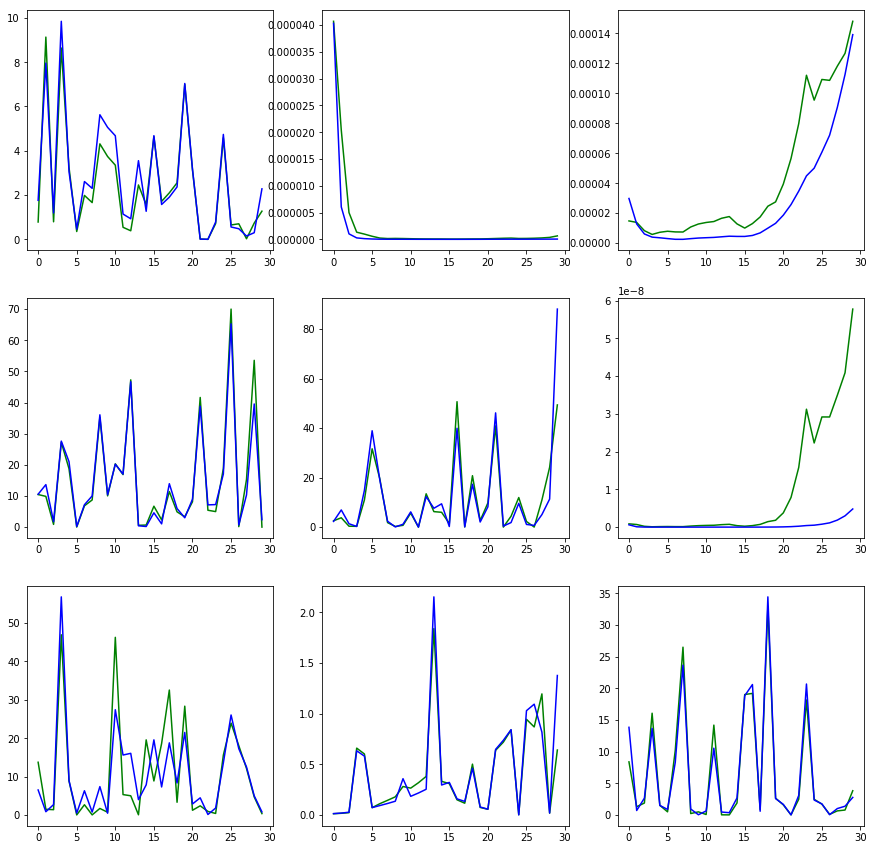

In [42]:
N=3
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(331+i)
    plt.plot(((Yvalid - Yprime1v)**2)[N,:,i], color='green')
    plt.plot(((Yvalid - Yprime2v)**2)[N,:,i], color='blue')
plt.show()

## ... But check what is actually happening. Look at neuron 1 again, in red now is the actual data and in green (linear) and blue (nonlinear) are the generated rates. What you can see is that nonlinear tends to be smoother. This is the effect of the dynamics. If the dynamics is not being fitted, then the generated rates more chance to respond to large jumps in the data, as neuron 1 shows.

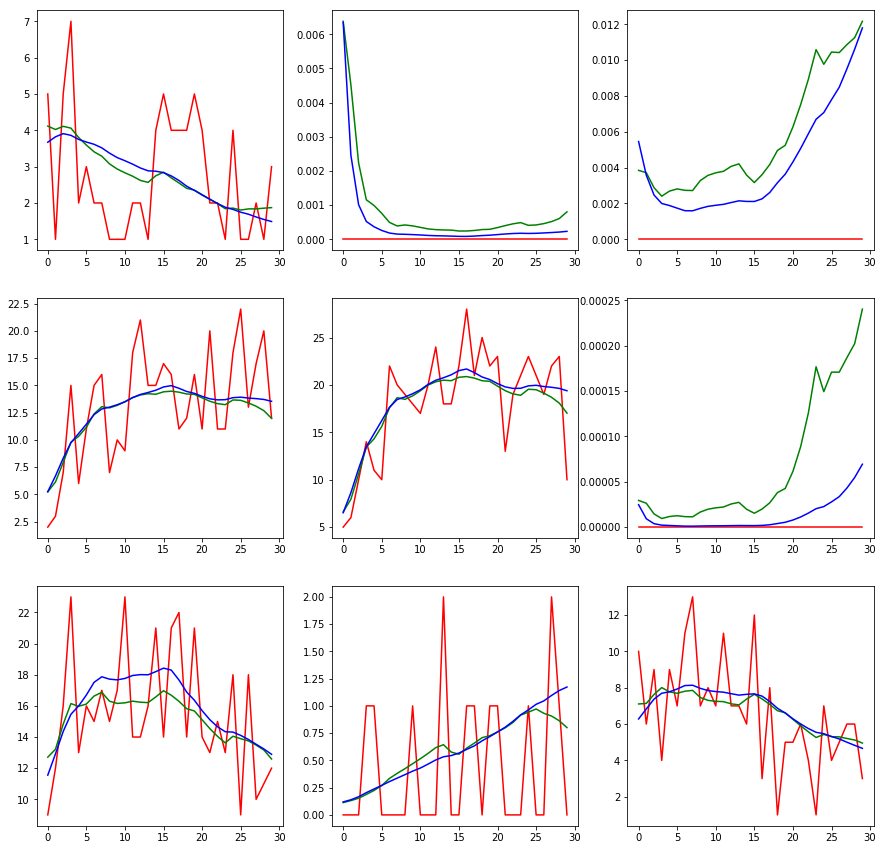

In [43]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(331+i)
    plt.plot(Yvalid[N,:,i], color='red')
    plt.plot(Yprime1v[N,:,i], color='green')
    plt.plot(Yprime2v[N,:,i], color='blue')
plt.show()

## Plot the trajectories + dynamics (linear)

### (Here only training data is shown)

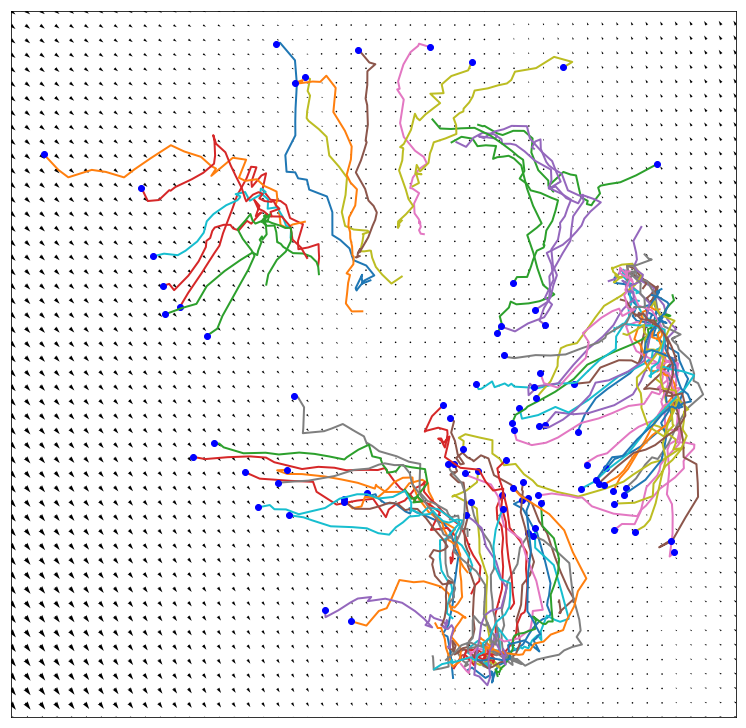

In [44]:
plt.figure(figsize=(13,13))
for samp in X_passed1:
    plt.plot(samp[:,0], samp[:,1], linewidth=2)
    plt.plot(samp[0,0], samp[0,1], 'bo')
    axes = plt.gca()
x1range, x2range = axes.get_xlim(), axes.get_ylim()
s = int(5*max(abs(x1range[0]) + abs(x1range[1]), abs(x2range[0]) + abs(x2range[1]))/3)

lattice = sgvb1.lat_ev_model.defineLattice(x1range, x2range)
Tbins = lattice.shape[0]
lattice = np.reshape(lattice, [1, Tbins, 2])
nextX = sgvb1.lat_ev_model.eval_nextX(lattice, withInflow=False).reshape(Tbins-1, 2)
X = lattice[:,:-1,:].reshape(Tbins-1, 2)

plt.quiver(X.T[0], X.T[1], nextX.T[0]-X.T[0], nextX.T[1]-X.T[1], color='black', scale=s)
axes = plt.gca()
axes.set_xlim(x1range)
axes.set_ylim(x2range)
plt.tick_params(axis='both',
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    left='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
# plt.savefig('/Users/danielhernandez/work/time_series/vae_nlds_rec_algo_v2/draft/figs/quiver_linearfit_poisson002.jpg')
plt.show()


## Plot the trajectories + dynamics (nonlinear)

### (Here only training data is shown)

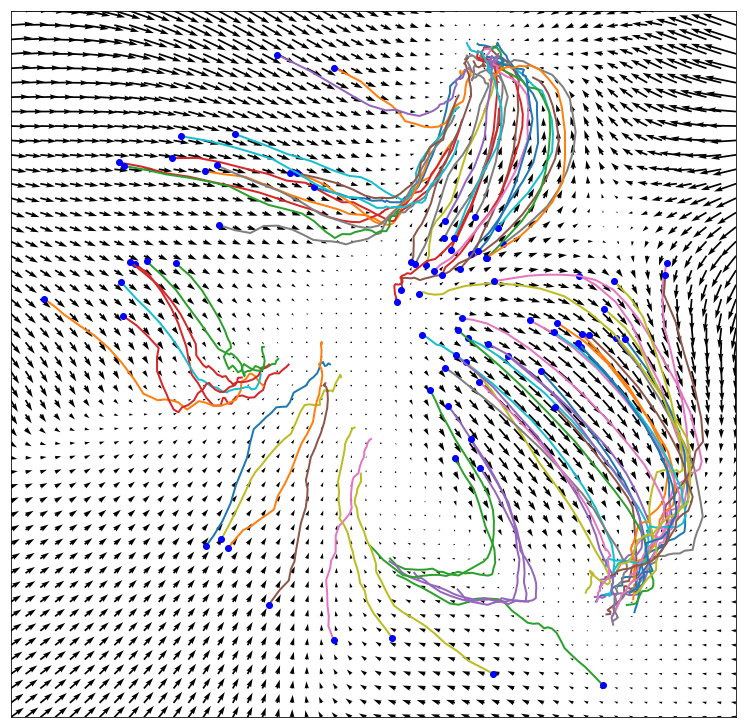

In [45]:
plt.figure(figsize=(13,13))
for samp in X_passed2:
    plt.plot(samp[:,0], samp[:,1], linewidth=2)
    plt.plot(samp[0,0], samp[0,1], 'bo')
    axes = plt.gca()
x1range, x2range = axes.get_xlim(), axes.get_ylim()
s = int(5*max(abs(x1range[0]) + abs(x1range[1]), abs(x2range[0]) + abs(x2range[1]))/3)

lattice = sgvb2.lat_ev_model.defineLattice(x1range, x2range)
Tbins = lattice.shape[0]
lattice = np.reshape(lattice, [1, Tbins, 2])
nextX = sgvb2.lat_ev_model.eval_nextX(lattice, withInflow=False).reshape(Tbins-1, 2)
X = lattice[:,:-1,:].reshape(Tbins-1, 2)

plt.quiver(X.T[0], X.T[1], nextX.T[0]-X.T[0], nextX.T[1]-X.T[1], color='black', scale=s)
axes = plt.gca()
axes.set_xlim(x1range)
axes.set_ylim(x2range)
plt.tick_params(axis='both',
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    left='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
# plt.savefig('/Users/danielhernandez/work/time_series/vae_nlds_rec_algo_v2/draft/figs/quiver_nonlinearfit_poisson002.jpg')
plt.show()

## The *k*MSE comparison

## As promised, nonlinear excels at this. linear just doesn't know what is doing.

In [53]:
k = 10

print 'alpha (linear):', sgvb1.lat_ev_model.alpha
print 'alpha (nonlinear):', sgvb2.lat_ev_model.alpha, '\n'

linear_kMSE_list = np.zeros(k)
nonlinear_kMSE_list = np.zeros(k)

Nsamps, Tbins, xDim = X_passed1.shape
Xconv1 = X_passed1
Xconv2 = X_passed2
# This loop stores at each iteration the corresponding kMSE
for i in range(k):
    # Evaluate the dynamics at every point in the paths
    totalA1 = sgvb1.lat_ev_model.totalA.eval({mrec1.X : Xconv1})
    totalA2 = sgvb2.lat_ev_model.totalA.eval({mrec2.X : Xconv2})
    
    # Some reshaping black magic so that we can just use tensor multiplication
    A1 = totalA1.reshape([Nsamps*(Tbins-i-1), xDim, xDim])
    A2 = totalA2.reshape([Nsamps*(Tbins-i-1), xDim, xDim])
    Xtemp1 = Xconv1[:,:-1,:].reshape(Nsamps*(Tbins-i-1), xDim)
    Xtemp2 = Xconv2[:,:-1,:].reshape(Nsamps*(Tbins-i-1), xDim)
    
    # Find the predicted paths at the subsequent time step, just using the fitted dynamics, then reshape back.
    Xconv1_nxt = np.einsum('ij,ijk->ik', Xtemp1, A1).reshape(Nsamps, Tbins-i-1, xDim)
    Xconv2_nxt = np.einsum('ij,ijk->ik', Xtemp2, A2).reshape(Nsamps, Tbins-i-1, xDim)
    
    # Use the found predicted path to generate predicted data
    Yprime1_nxt = mgen1.eval_Rate(Xconv1_nxt)
    Yprime2_nxt = mgen2.eval_Rate(Xconv2_nxt)
    
    # Make the predicted path the input for the next loop iteration
    Xconv1 = Xconv1_nxt
    Xconv2 = Xconv2_nxt

    # Compute the kMSE 
    DY1_nxt = Ytrain[:,i+1:,:] - Yprime1_nxt
    DY2_nxt = Ytrain[:,i+1:,:] - Yprime2_nxt
    linear_kMSE_list[i] = np.mean(DY1_nxt**2)
    nonlinear_kMSE_list[i] = np.mean(DY2_nxt**2)

print 'Linear:', np.mean(DY1_nxt**2)
print 'Nonlinear:', np.mean(DY2_nxt**2)

alpha (linear): 0.0
alpha (nonlinear): 0.1 

Linear: 9.82181330047
Nonlinear: 4.41433410163


In [54]:
k = 10

print 'alpha (linear):', sgvb1.lat_ev_model.alpha
print 'alpha (nonlinear):', sgvb2.lat_ev_model.alpha, '\n'

linear_valid_kMSE_list = np.zeros(k)
nonlinear_valid_kMSE_list = np.zeros(k)

Nsamps, Tbins, xDim = X_passed_valid1.shape
Xconv1 = X_passed_valid1
Xconv2 = X_passed_valid2
# This loop stores at each iteration the corresponding kMSE
for i in range(k):
    # Evaluate the dynamics at every point in the paths
    totalA1 = sgvb1.lat_ev_model.totalA.eval({mrec1.X : Xconv1})
    totalA2 = sgvb2.lat_ev_model.totalA.eval({mrec2.X : Xconv2})
    
    # Some reshaping black magic so that we can just use tensor multiplication
    A1 = totalA1.reshape([Nsamps*(Tbins-i-1), xDim, xDim])
    A2 = totalA2.reshape([Nsamps*(Tbins-i-1), xDim, xDim])
    Xtemp1 = Xconv1[:,:-1,:].reshape(Nsamps*(Tbins-i-1), xDim)
    Xtemp2 = Xconv2[:,:-1,:].reshape(Nsamps*(Tbins-i-1), xDim)
    
    # Find the predicted paths at the subsequent time step, just using the fitted dynamics, then reshape back.
    Xconv1_nxt = np.einsum('ij,ijk->ik', Xtemp1, A1).reshape(Nsamps, Tbins-i-1, xDim)
    Xconv2_nxt = np.einsum('ij,ijk->ik', Xtemp2, A2).reshape(Nsamps, Tbins-i-1, xDim)
    
    # Use the found predicted path to generate predicted data
    Yprime1_nxt = mgen1.eval_Rate(Xconv1_nxt)
    Yprime2_nxt = mgen2.eval_Rate(Xconv2_nxt)
    
    # Make the predicted path the input for the next loop iteration
    Xconv1 = Xconv1_nxt
    Xconv2 = Xconv2_nxt

    # Compute the kMSE 
    DY1_nxt = Yvalid[:,i+1:,:] - Yprime1_nxt
    DY2_nxt = Yvalid[:,i+1:,:] - Yprime2_nxt
    linear_valid_kMSE_list[i] = np.mean(DY1_nxt**2)
    nonlinear_valid_kMSE_list[i] = np.mean(DY2_nxt**2)

print 'Linear:', np.mean(DY1_nxt**2)
print 'Nonlinear:', np.mean(DY2_nxt**2)

alpha (linear): 0.0
alpha (nonlinear): 0.1 

Linear: 12.7419010502
Nonlinear: 5.07602483797


## We can plot it to see it better

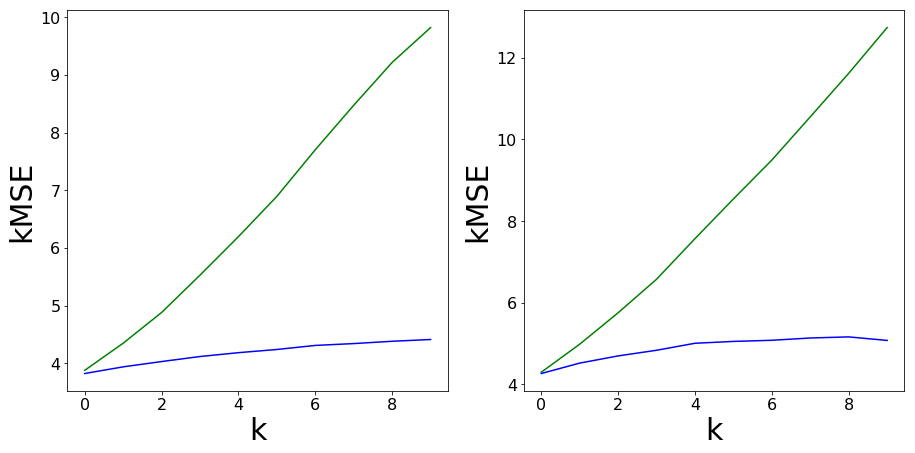

In [61]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
plt.plot(linear_kMSE_list, color='green')
plt.plot(nonlinear_kMSE_list, color='blue')
ax.set_xlabel("k", fontsize=30)
ax.set_ylabel("kMSE", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.savefig('/Users/danielhernandez/work/time_series/vae_nlds_rec_algo_v2/draft/figs/kMSE_pss1-nl.jpg')

ax = fig.add_subplot(122)
plt.plot(linear_valid_kMSE_list, color='green')
plt.plot(nonlinear_valid_kMSE_list, color='blue')
ax.set_xlabel("k", fontsize=30)
ax.set_ylabel("kMSE", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.savefig('/Users/danielhernandez/work/time_series/vae_nlds_rec_algo_v2/draft/figs/kMSE_pss1-nl.jpg')
plt.show()